# Infer EC50 values for the `Inna April 2016` chip

## To do

* Can't find the FACS XML files for this experiment

## Import `Python` modules

In [1]:
import os
import sys
import re
import glob

import xml.etree.ElementTree as ET
sys.path.append("/home/jupyter/tacc-work/jupyter_packages/lib/python2.7/site-packages")
from FlowCytometryTools import *

import numpy as np
import pandas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)

# Initialize directories
resultsdir = "results/Inna_April_2016"
resultsdir_parse_metadata = os.path.join(resultsdir, 'parse_metadata')
dirs = [resultsdir, resultsdir_parse_metadata]
for dir_i in dirs:
    if not os.path.isdir(dir_i):
        os.makedirs(dir_i)

## Make the input experimental-summary file

### Specify all inputs

In [7]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_4'

# Specify the locations of directories with FCS files with part of the FACS data 
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_55675', 'Job_56037', 'Job_55889']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "Inna April 2016"
ignore_aq_item_ids = '118852'

# Specify the output metadata CSV file
output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Read in input arguments, as if it were a new script
job_ids = job_ids.split(',')
facs_dirs = facs_dirs.split(',')
xml_files = xml_files.split(',')
ignore_aq_item_ids = ignore_aq_item_ids.split(',')

# Read in data on location of deep-sequencing data
fastq_summary_file = os.path.join(fastq_dir, 'run_4.csv')
fastq_df = pandas.read_csv(fastq_summary_file)
fastq_df

# Remove entires to ignore 
indices_to_drop = [i for (i, row) in fastq_df.iterrows() if row['aq_item_id'] in ignore_aq_item_ids]
fastq_df.drop(indices_to_drop, inplace=True)

# Piece together paths to FASTQ files and tweak some of entries to match
# expected patterns/cases
fastq_df['fastq_id'] = fastq_df.apply(lambda row: os.path.join(row['aq_item_id'], row['filename_prefix']), axis=1)
fastq_df['protease'] = fastq_df['protease'].apply(lambda x: x.lower())
fastq_df['strain'] = fastq_df['strain'].apply(lambda x: x.replace(' ', '_'))

# Index by protease name and concentration
fastq_df.set_index(['protease', 'concentration'], inplace=True)
fastq_df.sort_index(inplace=True)

# Downsample to include only samples within library of interest
#fastq_df = fastq_df[fastq_df['strain']==library_name]
fastq_df

aq_item_id        filename_prefix           strain  \
protease     concentration                                                      
chymotrypsin 9.5               118855    A_Aprilexp1round1_4  Inna_April_2016   
             28.0              118856    A_Aprilexp1round1_5  Inna_April_2016   
             83.0              118863    A_Aprilexp1round2_3  Inna_April_2016   
             250.0             118864    A_Aprilexp1round2_4  Inna_April_2016   
             750.0             118859    A_Aprilexp1round3_3  Inna_April_2016   
             2250.0            118860    A_Aprilexp1round3_4  Inna_April_2016   
trypsin      0.0                naive  run2-09-jan25-2018_S9  Inna_April_2016   
             9.5               118853    A_Aprilexp1round1_2  Inna_April_2016   
             28.0              118854    A_Aprilexp1round1_3  Inna_April_2016   
             83.0              118861    A_Aprilexp1round2_1  Inna_April_2016   
             250.0             118862    A_Aprilexp1round2_2  Inna_April_2016   
             750.0             118857    A_Aprilexp1round3_1  Inna_April_2016   
             2250.0            118858    A_Aprilexp1round3_2  Inna_April_2016   

                                               fastq_id  
protease     concentration                               
chymotrypsin 9.5             118855/A_Aprilexp1round1_4  
             28.0            118856/A_Aprilexp1round1_5  
             83.0            118863/A_Aprilexp1round2_3  
             250.0           118864/A_Aprilexp1round2_4  
             750.0           118859/A_Aprilexp1round3_3  
             2250.0          118860/A_Aprilexp1round3_4  
trypsin      0.0            naive/run2-09-jan25-2018_S9  
             9.5             118853/A_Aprilexp1round1_2  
             28.0            118854/A_Aprilexp1round1_3  
             83.0            118861/A_Aprilexp1round2_1  
             250.0           118862/A_Aprilexp1round2_2  
             750.0           118857/A_Aprilexp1round3_1  
             2250.0          118858/A_Aprilexp1round3_2

### For each sample in the experiment, quantify the number of total number of events and the number of events that passed the sorting threshold

In [8]:
def s_log(sample, channel_names):
    new_sample = sample.copy()
    new_data = new_sample.data

    for channel_name in channel_names:
        new_data[channel_name] = np.log10(new_data[channel_name])
        
    new_data.replace(to_replace = -np.inf, value = -1, inplace = True)
    new_data = new_data.dropna()
    new_sample.data = new_data
    
    return new_sample

In [9]:
# Read in data from the `manifest.txt` files
manifest_df = pandas.DataFrame()
for (job_id, facs_dir) in zip(job_ids, facs_dirs):
    df = pandas.read_csv(os.path.join(facs_dir, 'manifest.txt'))
    df['job_id'] = job_id
    df['directory'] = facs_dir
    df['specimen'] = df['filename'].apply(lambda x : x[:12])
    df['tube'] = df['filename'].apply(lambda x : x[13:21])
    manifest_df = pandas.concat([manifest_df, df])
manifest_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)

# Quantify the total number of events and events passing the gate
fitc_data_dict = {}
total_number_of_recorded_events = []
number_of_events_passing_fitc_gate = []
for (i, row) in manifest_df.iterrows():
    
    # Read in the data for the appropriate channel and transform it to a log10 scale
    fcs_file = os.path.join(row['directory'], row['filename'])
    sample = FCMeasurement(ID='Test Sample', datafile=fcs_file)
    #print("Analyzing the channel: {0}".format(channel_name))
    sample = s_log(sample, [facs_channel_name])
    df = sample.data
    
    # Count the number of total events and events passing the gate
    total_number_of_recorded_events.append(len(df.index.values))
    number_of_events_passing_fitc_gate.append(
        sum(df[facs_channel_name] > 3.0)
    )

# Append the FACS data to the manifest dataframe
manifest_df['total_number_of_recorded_events'] = total_number_of_recorded_events
manifest_df['number_of_events_passing_fitc_gate'] = number_of_events_passing_fitc_gate
manifest_df['fraction_collected'] = \
    manifest_df['number_of_events_passing_fitc_gate'] / manifest_df['total_number_of_recorded_events']
columns_to_show = [
    'strain', 'protease', 'concentration', 'total_number_of_recorded_events',
    'number_of_events_passing_fitc_gate', 'fraction_collected'
]
manifest_df[columns_to_show]

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


strain      protease  \
job_id    specimen     tube                                              
Job_55675 Round_1_Tube 006_006.          Inna April 2016       trypsin   
                       007_007.          Inna April 2016       trypsin   
                       008_008.          Inna April 2016  chymotrypsin   
                       009_009.          Inna April 2016  chymotrypsin   
                       010_010.          Inna April 2016       trypsin   
                       002_002.  EBY100 + PETCONv3_baker       trypsin   
                       003_003.                AMA1-best       trypsin   
                       004_004.                AMA1-best       trypsin   
                       005_005.                AMA1-best  chymotrypsin   
Job_56037 Round_3_Tube 006_006.          Inna April 2016       trypsin   
                       007_007.          Inna April 2016       trypsin   
                       008_008.          Inna April 2016  chymotrypsin   
                       009_009.          Inna April 2016  chymotrypsin   
                       002_002.  EBY100 + PETCONv3_baker       trypsin   
                       003_003.                AMA1-best       trypsin   
                       004_004.                AMA1-best       trypsin   
                       005_005.                AMA1-best  chymotrypsin   
Job_55889 Round_2_Tube 006_006.          Inna April 2016       trypsin   
                       007_007.          Inna April 2016       trypsin   
                       008_008.          Inna April 2016  chymotrypsin   
                       009_009.          Inna April 2016  chymotrypsin   
                       002_002.  EBY100 + PETCONv3_baker       trypsin   
                       003_003.                AMA1-best       trypsin   
                       004_004.                AMA1-best       trypsin   
                       005_005.                AMA1-best  chymotrypsin   

                                 concentration  \
job_id    specimen     tube                      
Job_55675 Round_1_Tube 006_006.            9.5   
                       007_007.           28.0   
                       008_008.            9.5   
                       009_009.           28.0   
                       010_010.            0.0   
                       002_002.            0.0   
                       003_003.            0.0   
                       004_004.          250.0   
                       005_005.          250.0   
Job_56037 Round_3_Tube 006_006.          750.0   
                       007_007.         2250.0   
                       008_008.          750.0   
                       009_009.         2250.0   
                       002_002.            0.0   
                       003_003.            0.0   
                       004_004.          250.0   
                       005_005.          250.0   
Job_55889 Round_2_Tube 006_006.           83.0   
                       007_007.          250.0   
                       008_008.           83.0   
                       009_009.          250.0   
                       002_002.            0.0   
                       003_003.            0.0   
                       004_004.          250.0   
                       005_005.          250.0   

                                 total_number_of_recorded_events  \
job_id    specimen     tube                                        
Job_55675 Round_1_Tube 006_006.                            99997   
                       007_007.                            99997   
                       008_008.                            99998   
                       009_009.                            99998   
                       010_010.                           100000   
                       002_002.                            99994   
                       003_003.                            99999   
                       004_004.                            99996   
                    

Read in data from the XML files on the total number of cells collected.

In [15]:
# Compile data in each XML file
xml_data_dict = {
    key : []
    for key in ['job_id', 'specimen', 'tube', 'cells_collected', 'intended_number_of_cells_collected'] #
}
cells_collected_pattern = re.compile(r'\w+ : (?P<cells_collected>\d+) / (?P<intended_number_of_cells_collected>\d+)')
for filename in xml_files:
    tree = ET.parse(filename)
    root = tree.getroot()

    # Get experiment metadata
    xml_data_dict['job_id'].append( root.findall(".//*[@name='Experiment']")[0].get('value') )
    xml_data_dict['specimen'].append( root.findall(".//*[@name='Specimen']")[0].get('value') )
    xml_data_dict['tube'].append( root.findall(".//*[@name='Tube']")[0].get('value') )
    
    # Get experiment counts
    cells_collected_data = root[4].findall(".//*[@col='1']")[0].text
    match = re.match(cells_collected_pattern, cells_collected_data)
    if match:
        xml_data_dict['cells_collected'].append(
            int(match.group('cells_collected'))
        )
        xml_data_dict['intended_number_of_cells_collected'].append(
            int(match.group('intended_number_of_cells_collected'))
        )
    else:
        xml_data_dict['cells_collected'].append(None)
        xml_data_dict['intended_number_of_cells_collected'].append(None)
          
# Convert data to a dataframe
xml_data_df = pandas.DataFrame.from_dict(xml_data_dict)
#xml_data_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)
xml_data_df.set_index(['job_id'], inplace=True)
#xml_data_df

In [18]:
xml_data_df.index.values

array(['Plan_8486', 'Plan_8486', 'Plan_8486', 'Plan_8486', 'Plan_8486',
       'Plan_8486', 'Job_57759', 'Job_57759', 'Job_57759', 'Job_57759',
       'Job_59575', 'Job_59575', 'Job_59575', 'Job_59575', 'Job_60063',
       'Job_60063', 'Job_60063', 'Job_60063', 'Job_58037', 'Job_58037',
       'Job_58037', 'Job_58037', 'Job_58037', 'Job_58037', 'Plan_8290',
       'Plan_8290', 'Plan_8290', 'Plan_8290', 'Plan_9312', 'Plan_9312',
       'Plan_9312', 'Plan_9312', 'Plan_9312', 'Plan_9312', 'Plan_9312',
       'Plan_9312', 'Plan_9312', 'Plan_9312', 'Plan_9312', 'Plan_9312',
       'Plan_9312', 'Plan_9312', 'Plan_9312', 'Plan_9312', 'Plan_8209',
       'Plan_8209', 'Plan_8209', 'Plan_8209', 'Plan_8209', 'job_59787',
       'job_59787', 'job_59787', 'job_59787', 'job_59787', 'Job_56243',
       'Job_56243', 'Job_56243', 'Job_56243', 'Job_56243', 'Job_57343',
       'Job_57343', 'Job_57343', 'Job_57343', 'Plan_8519', 'Plan_8519',
       'Plan_8519', 'Plan_8519', 'Job_56497', 'Job_56497', 'Job_

In [17]:
xml_data_df.loc['Job_55675']

KeyError: u'the label [Job_55675] is not in the [index]'

Merge the FACS data from the two input sources

In [11]:
facs_df = manifest_df.merge(xml_data_df, left_index=True, right_index=True, how='left')
facs_df = facs_df[
    facs_df['strain'] == library_name
]
facs_df.set_index(['protease', 'concentration'], inplace=True)
columns_to_show = ['cells_collected', 'fraction_collected']
#facs_df[columns_to_show]

cells_collected  fraction_collected
protease     concentration                                     
trypsin      9.5                        NaN            0.216546
             28.0                       NaN            0.178465
chymotrypsin 9.5                        NaN            0.202774
             28.0                       NaN            0.181494
trypsin      0.0                        NaN            0.226890
             83.0                       NaN            0.609290
             250.0                      NaN            0.524160
chymotrypsin 83.0                       NaN            0.624870
             250.0                      NaN            0.508095
trypsin      750.0                      NaN            0.179174
             2250.0                     NaN            0.016701
chymotrypsin 750.0                      NaN            0.244487
             2250.0                     NaN            0.102944

Merge the FACS and deep-sequencing data

In [7]:
df = fastq_df.merge(facs_df, left_index=True, right_index=True, how="outer")
columns_to_write = ['fastq_id', 'cells_collected', 'fraction_collected']
df = df[columns_to_write]
df.reset_index(inplace=True)
df

,protease,concentration,fastq_id,cells_collected,fraction_collected
0,chymotrypsin,9.5,118855/A_Aprilexp1round1_4,1200000.0,0.189052
1,chymotrypsin,28.0,118856/A_Aprilexp1round1_5,1200000.0,0.174285
2,chymotrypsin,83.0,118863/A_Aprilexp1round2_3,5641051.0,0.636093
3,chymotrypsin,250.0,118864/A_Aprilexp1round2_4,5631873.0,0.505090
4,chymotrypsin,750.0,118859/A_Aprilexp1round3_3,2564592.0,0.305309
5,chymotrypsin,2250.0,118860/A_Aprilexp1round3_4,1127664.0,0.128904
6,trypsin,0.0,naive/run2-09-jan25-2018_S9,1200000.0,0.208038
7,trypsin,9.5,118853/A_Aprilexp1round1_2,1200000.0,0.182106
8,trypsin,28.0,118854/A_Aprilexp1round1_3,1200000.0,0.166087
9,trypsin,83.0,118861/A_Aprilexp1round2_1,7560000.0,0.628806


Add a row for a naive sample for chymotrypsin, using the same deep-sequencing data as for trypsin 

In [8]:
df_with_extra_row = pandas.DataFrame.from_dict(
    {
        'protease' : ['chymotrypsin'],
        'concentration' : [0],
        'fastq_id' : [df.iloc[6]['fastq_id']],
        'cells_collected' : [df.iloc[6]['cells_collected']],
        'fraction_collected' : [df.iloc[6]['fraction_collected']]
    }
)
df_with_extra_row
df = pandas.concat([df, df_with_extra_row])

Show concatenated dataframe, sorted by protease and protease concentration.

In [9]:
df.sort_values(by=['protease', 'concentration'], inplace=True)
df

,cells_collected,concentration,fastq_id,fraction_collected,protease
0,1200000.0,0.0,naive/run2-09-jan25-2018_S9,0.208038,chymotrypsin
0,1200000.0,9.5,118855/A_Aprilexp1round1_4,0.189052,chymotrypsin
1,1200000.0,28.0,118856/A_Aprilexp1round1_5,0.174285,chymotrypsin
2,5641051.0,83.0,118863/A_Aprilexp1round2_3,0.636093,chymotrypsin
3,5631873.0,250.0,118864/A_Aprilexp1round2_4,0.505090,chymotrypsin
4,2564592.0,750.0,118859/A_Aprilexp1round3_3,0.305309,chymotrypsin
5,1127664.0,2250.0,118860/A_Aprilexp1round3_4,0.128904,chymotrypsin
6,1200000.0,0.0,naive/run2-09-jan25-2018_S9,0.208038,trypsin
7,1200000.0,9.5,118853/A_Aprilexp1round1_2,0.182106,trypsin
8,1200000.0,28.0,118854/A_Aprilexp1round1_3,0.166087,trypsin


Tweak the FASTQ IDs to match the actual paths, replacing some of the underscores with dashes

In [10]:
new_fastq_ids = []
for (i, row) in df.iterrows():
    fastq_id = row['fastq_id']
    if 'A_April' in fastq_id:
        new_fastq_ids.append(fastq_id.replace('_', '-'))
    else:
        new_fastq_ids.append(fastq_id)
df['old_fastq_id'] = df['fastq_id']
df['fastq_id'] = new_fastq_ids
df

,cells_collected,concentration,fastq_id,fraction_collected,protease,old_fastq_id
0,1200000.0,0.0,naive/run2-09-jan25-2018_S9,0.208038,chymotrypsin,naive/run2-09-jan25-2018_S9
0,1200000.0,9.5,118855/A-Aprilexp1round1-4,0.189052,chymotrypsin,118855/A_Aprilexp1round1_4
1,1200000.0,28.0,118856/A-Aprilexp1round1-5,0.174285,chymotrypsin,118856/A_Aprilexp1round1_5
2,5641051.0,83.0,118863/A-Aprilexp1round2-3,0.636093,chymotrypsin,118863/A_Aprilexp1round2_3
3,5631873.0,250.0,118864/A-Aprilexp1round2-4,0.505090,chymotrypsin,118864/A_Aprilexp1round2_4
4,2564592.0,750.0,118859/A-Aprilexp1round3-3,0.305309,chymotrypsin,118859/A_Aprilexp1round3_3
5,1127664.0,2250.0,118860/A-Aprilexp1round3-4,0.128904,chymotrypsin,118860/A_Aprilexp1round3_4
6,1200000.0,0.0,naive/run2-09-jan25-2018_S9,0.208038,trypsin,naive/run2-09-jan25-2018_S9
7,1200000.0,9.5,118853/A-Aprilexp1round1-2,0.182106,trypsin,118853/A_Aprilexp1round1_2
8,1200000.0,28.0,118854/A-Aprilexp1round1-3,0.166087,trypsin,118854/A_Aprilexp1round1_3


Manually add missing columns

In [11]:
# Add columns
df['experiment_id'] = 'Inna_April_2016_rep1'
df['selection_strength'] = 2 * [i for i in range(0,7)]
df['conc_factor'] = 2 * ['', '3', '3', '3', '3', '3', '3']
df['parent'] = 2 * ['', '0', '0', '2', '2', '4', '4']
df['parent_expression'] = 2 * ['', 0.208038, 0.208038, '', '', '', '']

# Rename columns
df.rename(
    {'protease':'protease_type'},
    inplace=True,
    axis='columns'
)
column_order = [
    'experiment_id', 'protease_type', 'concentration', 'selection_strength', 'parent', 'conc_factor', 'fastq_id',
    'parent_expression', 'fraction_collected', 'cells_collected'
]
df[column_order]

,experiment_id,protease_type,concentration,selection_strength,parent,conc_factor,fastq_id,parent_expression,fraction_collected,cells_collected
0,Inna_April_2016_rep1,chymotrypsin,0.0,0,,,naive/run2-09-jan25-2018_S9,,0.208038,1200000.0
0,Inna_April_2016_rep1,chymotrypsin,9.5,1,0,3,118855/A-Aprilexp1round1-4,0.208038,0.189052,1200000.0
1,Inna_April_2016_rep1,chymotrypsin,28.0,2,0,3,118856/A-Aprilexp1round1-5,0.208038,0.174285,1200000.0
2,Inna_April_2016_rep1,chymotrypsin,83.0,3,2,3,118863/A-Aprilexp1round2-3,,0.636093,5641051.0
3,Inna_April_2016_rep1,chymotrypsin,250.0,4,2,3,118864/A-Aprilexp1round2-4,,0.505090,5631873.0
4,Inna_April_2016_rep1,chymotrypsin,750.0,5,4,3,118859/A-Aprilexp1round3-3,,0.305309,2564592.0
5,Inna_April_2016_rep1,chymotrypsin,2250.0,6,4,3,118860/A-Aprilexp1round3-4,,0.128904,1127664.0
6,Inna_April_2016_rep1,trypsin,0.0,0,,,naive/run2-09-jan25-2018_S9,,0.208038,1200000.0
7,Inna_April_2016_rep1,trypsin,9.5,1,0,3,118853/A-Aprilexp1round1-2,0.208038,0.182106,1200000.0
8,Inna_April_2016_rep1,trypsin,28.0,2,0,3,118854/A-Aprilexp1round1-3,0.208038,0.166087,1200000.0


Write the above dataframe to an output file

In [12]:
print("Writing metadata to the experimental summary file: {0}".format(output_file))
df[column_order].to_csv(output_file, index=False)

Writing metadata to the experimental summary file: results/Inna_April_2016/parse_metadata/experimental_metadata_from_script.csv


## Compute EC50 values from the input deep-sequencing and FACS data

In [13]:
# Define input variables
data_dir = 'data/160401_chip/'
designed_sequences_file = os.path.join(data_dir, 'designed_protein_sequences.csv')
experimental_summary_file = os.path.join(output_file)
fastq_dir = fastq_dir
pear_path = '/home/05402/haddox/software/pear/bin/pear'
output_dir = resultsdir

In [14]:
# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/compute_ec50_values_from_deep_sequencing_data.py',
    '--designed_sequences_file {0}'.format(designed_sequences_file),
    '--experimental_summary_file {0}'.format(experimental_summary_file),
    '--fastq_dir {0}'.format(fastq_dir),
    '--pear_path {0}'.format(pear_path),
    '--output_dir {0}'.format(output_dir)
])

#! {cmd}
print(cmd)

python scripts/compute_ec50_values_from_deep_sequencing_data.py --designed_sequences_file data/160401_chip/designed_protein_sequences.csv --experimental_summary_file results/Inna_April_2016/parse_metadata/experimental_metadata_from_script.csv --fastq_dir /work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_4 --pear_path /home/05402/haddox/software/pear/bin/pear --output_dir results/Inna_April_2016


## To do:

* Quantify sequencing depth
* Look at the distribution of counts over time

Quantify the number of assembled reads per sample

In [28]:
def ParsePAREOutfile(outfile):
    """
    This function parses the output data generated by PARE when assemblying paired-end reads
    
    Args:
        `outfile`: the path to a file with the output data generated by PARE
        
    Returns:
        A tupple with the following three variables in the order they appear in the below list:
            `n_assembled_reads` : the total number of assembled reads
            `n_discarded_reads` : the total number of discarded reads
            `n_non_assembled_reads` : the total number of non_assembled_reads
    """
    
    # Pattern used to extract data
    n_reads_pattern = re.compile(r'\: (?P<n_reads>[\d,]+) /')
    
    # Use regular expressions to extract the relevant info from the file
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = n_total_reads = None
    with open(outfile) as f:
        #print(f.readlines())
        for line in f:
            if 'Assembled reads .' in line:
                if n_assembled_reads:
                    raise ValueError("Already found data for `n_assembled_reads`")
                n_assembled_match = re.search(n_reads_pattern, line)
                n_assembled_reads = int(n_assembled_match.group('n_reads').replace(',', ''))
                
            elif 'Discarded reads .' in line:
                if n_discarded_reads:
                    raise ValueError("Already found data for `n_discarded_reads`")
                n_discarded_match = re.search(n_reads_pattern, line)
                n_discarded_reads = int(n_discarded_match.group('n_reads').replace(',', ''))
                
            elif 'Not assembled reads .' in line:
                if n_non_assembled_reads:
                    raise ValueError("Already found data for `n_non_assembled_reads`")
                n_non_assembled_match = re.search(n_reads_pattern, line)
                n_non_assembled_reads = int(n_non_assembled_match.group('n_reads').replace(',', ''))
    
    return (n_assembled_reads, n_discarded_reads, n_non_assembled_reads)


In [26]:
# Find log files from PARE
pare_log_dir = os.path.join(resultsdir, 'paired_FASTQ_files')

selection_indices = list(range(0,7))
experiment_names = ['trypsin_{0}'.format(i) for i in selection_indices] + \
    ['chymotrypsin_{0}'.format(i) for i in selection_indices]
log_files = glob.glob(os.path.join(pare_log_dir, '*.log'))
log_files_dict = {
    experiment_name : []
    for experiment_name in experiment_names
}
# For each log file, look for an experimental name that matches the beginning
# of the base name of the log file
for log_file_name in log_files:
    matching_experiments = []
    for experiment_name in log_files_dict:
        log_file_basename = os.path.basename(log_file_name)
        if log_file_basename.find('{0}-'.format(experiment_name)) == 0:
            log_files_dict[experiment_name].append(log_file_name)
            matching_experiments.append(experiment_name)
    if len(matching_experiments) == 0:
        raise ValueError("Could not find a matching experiment for the log file: {0}".format(log_file_name))
    if len(matching_experiments) > 1:
        print(matching_experiments)
        raise ValueError("Found multiple matching experiments for the log file: {0}".format(log_file_name))
    assert len(matching_experiments) == 1

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text yticklabel objects>)

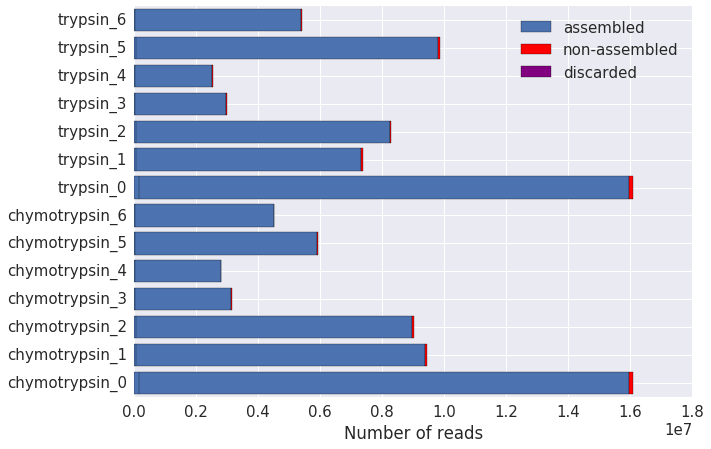

In [55]:
# Read in depth and quality scores from the output of the `PEAR` program and store in a pandas dataframe
assembly_d = {
    key : []
    for key in ['experiment_name', 'n_assembled_reads', 'n_discarded_reads', 'n_non_assembled_reads']
}
for experiment_name in log_files_dict:
    assembly_d['experiment_name'].append(experiment_name)
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = 0
    for log_file_name in log_files_dict[experiment_name]:
        (n_assembled_reads_i, n_discarded_reads_i, n_non_assembled_reads_i) = \
            ParsePAREOutfile(log_file_name)
        n_assembled_reads += n_assembled_reads_i
        n_discarded_reads += n_discarded_reads_i
        n_non_assembled_reads += n_non_assembled_reads_i
    assembly_d['n_assembled_reads'].append(n_assembled_reads)
    assembly_d['n_discarded_reads'].append(n_discarded_reads)
    assembly_d['n_non_assembled_reads'].append(n_non_assembled_reads)

assembly_df = pandas.DataFrame.from_dict(assembly_d)

# Plot the data for each replicate as stacked bar charts
fig = plt.figure(figsize=(10,7))

# Get data for each bar
assembly_df.set_index('experiment_name', inplace=True)
labels = sorted(assembly_df.index.values)
first_bar = assembly_df.loc[labels]['n_assembled_reads']
second_bar = assembly_df.loc[labels]['n_non_assembled_reads']
third_bar = assembly_df.loc[labels]['n_discarded_reads']
assert(len(first_bar) == len(second_bar))

# Make plot
plot_indices = np.arange(len(first_bar))
width = 0.35
plt.barh(plot_indices, first_bar, label='assembled', align='center')
plt.barh(plot_indices, second_bar, left=first_bar, label='non-assembled', color='red', align='center')
plt.barh(plot_indices, third_bar, left=second_bar, label='discarded', color='purple', align='center')
plt.yticks(plot_indices, labels)
plt.xlabel('Number of reads')
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
def adjust_ylim(l):
    mn, mx = l
    mn += 1.5
    mx -= .5
    return (mn, mx)
plt.ylim(adjust_ylim(plt.ylim()))
plt.yticks()

For each sequence, find the minimum stability score across both proteases

In [24]:
trypsin_df = pandas.read_csv('results/Inna_April_2016/stability_scores/trypsin_stability_scores.txt', sep='\t')
trypsin_df.set_index('name', inplace=True)
chymotrypsin_df = pandas.read_csv('results/Inna_April_2016/stability_scores/chymotrypsin_stability_scores.txt', sep='\t')
chymotrypsin_df.set_index('name', inplace=True)
stability_scores_df = trypsin_df.merge(
    chymotrypsin_df,
    left_index=True, right_index=True, how='outer', suffixes=['_t', '_c'])
stability_scores_df['stabilityscore'] = stability_scores_df.apply(
    lambda row: min(row['stabilityscore_t'], row['stabilityscore_c']), axis=1
)
stability_scores_df[['stabilityscore', 'stabilityscore_t', 'stabilityscore_c']]

,stabilityscore,stabilityscore_t,stabilityscore_c
name,,,
100.pdb.dna_protein.seq,-1.115577,-0.425003,-1.115577
101.pdb.dna_protein.seq,-1.496851,0.855269,-1.496851
102.pdb.dna_protein.seq,-1.564880,-0.140498,-1.564880
103.pdb.dna_protein.seq,-1.092519,-0.229162,-1.092519
106.pdb.dna_protein.seq,-0.971438,-0.321572,-0.971438
107.pdb.dna_protein.seq,-0.734256,0.314923,-0.734256
111.pdb.dna_protein.seq,-1.121194,0.095515,-1.121194
113.pdb.dna_protein.seq,-1.154108,-0.493180,-1.154108
115.pdb.dna_protein.seq,-1.038595,-0.156188,-1.038595


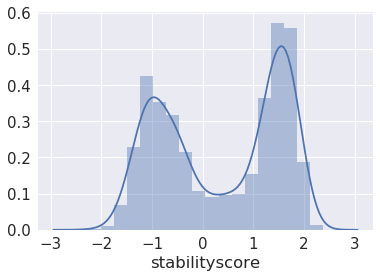

In [25]:
sns.distplot(stability_scores_df['stabilityscore'])

## Old code

Old code for making the experimental summary file through a separate script

In [ ]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_4'

# Specify the locations of directories with FCS files with part of the FACS data 
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_56649', 'Job_56497', 'Job_56243']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "Inna_April_2016"
ignore_aq_item_ids = '118852'

# Specify the output metadata CSV file
output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Carry out the command
cmd = ' '.join([
    'python',
    'scripts/parse_metadata.py',
    '--fastq_dir {0}'.format(fastq_dir),
    "--job_ids {0}".format(job_ids),
    "--facs_dirs {0}".format(facs_dirs),
    "--facs_channel_name {0}".format(facs_channel_name),
    "--xml_files {0}".format(xml_files),
    "--library_name {0}".format(library_name),
    "--ignore_aq_item_ids".format(ignore_aq_item_ids),
    "--output_file {0}".format(output_file)
])

! {cmd}